In [1]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class IWAE(nn.Module):
#     def __init__(self, latent_dim, num_samples):
#         super(IWAE, self).__init__()
#         self.latent_dim = latent_dim
#         self.num_samples = num_samples

#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv3d(1, 32, kernel_size=(1,1,7), stride=(1,1,2), padding=(0,0,3)),
#             nn.ReLU(),
#             nn.Conv3d(32, 64, kernel_size=(3,3,5), stride=(1,1,2), padding=(1,1,2)),
#             nn.ReLU(),
#             nn.Conv3d(64, 128, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1)),
#             nn.ReLU(),
#             nn.Conv3d(128, 256, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1)),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(256 * 6 * 6 * 82, 512),
#             nn.ReLU(),
#             nn.Linear(512, self.latent_dim * 2)
#         )

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(self.latent_dim, 512),
#             nn.ReLU(),
#             nn.Linear(512, 256 * 6 * 6 * 82),
#             nn.ReLU(),
#             nn.Unflatten(1, (256, 6, 6, 82)),
#             nn.ConvTranspose3d(256, 128, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1), output_padding=(1,1,1)),
#             nn.ReLU(),
#             nn.ConvTranspose3d(128, 64, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1), output_padding=(1,1,1)),
#             nn.ReLU(),
#             nn.ConvTranspose3d(64, 32, kernel_size=(3,3,5), stride=(1,1,2), padding=(1,1,2), output_padding=(0,0,1)),
#             nn.ReLU(),
#             nn.ConvTranspose3d(32, 1, kernel_size=(1,1,7), stride=(1,1,2), padding=(0,0,3), output_padding=(0,0,1)), 
#         )

#     def encode(self, x):
#         h = self.encoder(x)
#         return torch.chunk(h, 2, dim=1)

#     def reparameterize(self, mu, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def decode(self, z):
#         return self.decoder(z)

#     def forward(self, x):
#         mu, log_var = self.encode(x)
        
#         # Generate multiple samples
#         z = self.reparameterize(mu.unsqueeze(1).repeat(1, self.num_samples, 1),
#                                 log_var.unsqueeze(1).repeat(1, self.num_samples, 1))
        
#         # Reshape for decoding
#         z_flat = z.view(-1, self.latent_dim)
#         x_recon = self.decode(z_flat)
        
#         # Reshape reconstruction to match input with samples
#         x_recon = x_recon.view(x.size(0), self.num_samples, *x.size()[1:])
        
#         return x_recon, mu, log_var, z

# def iwae_loss(x_recon, x, mu, log_var, z, num_samples):
#     # Expand x to match the sample dimension of x_recon
#     x_expanded = x.unsqueeze(1).expand(-1, num_samples, -1, -1, -1, -1)
    
#     # Compute log p(x|z)
#     log_p_x_given_z = -F.binary_cross_entropy_with_logits(x_recon, x_expanded, reduction='none').sum(dim=[2,3,4,5])
    
#     # Compute log p(z)
#     log_p_z = -0.5 * torch.sum(z**2, dim=-1)
    
#     # Compute log q(z|x)
#     log_q_z_given_x = -0.5 * torch.sum(log_var.unsqueeze(1) + (z - mu.unsqueeze(1))**2 / log_var.exp().unsqueeze(1), dim=-1)
    
#     # Compute log weights
#     log_w = log_p_x_given_z + log_p_z - log_q_z_given_x
    
#     # Compute IWAE loss
#     return -torch.logsumexp(log_w, dim=1).mean() + torch.log(torch.tensor(num_samples))

In [1]:
import torch
import torch.nn as nn
import torch.distributions as td
import torch.nn.functional as F

class IWAE(nn.Module):
    def __init__(self, input_shape, latent_dim, num_samples):
        super(IWAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_samples = num_samples
        self.input_shape = input_shape

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(1,1,7), stride=(1,1,2), padding=(0,0,3)),
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=(3,3,5), stride=(1,1,2), padding=(1,1,2)),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1)),
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1)),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(256 * 6 * 6 * 82, latent_dim)
        self.fc_logvar = nn.Linear(256 * 6 * 6 * 82, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 6 * 6 * 82),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(256, 128, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1), output_padding=(1,1,1)),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=(3,3,3), stride=(2,2,2), padding=(1,1,1), output_padding=(1,1,1)),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 32, kernel_size=(3,3,5), stride=(1,1,2), padding=(1,1,2), output_padding=(0,0,1)),
            nn.ReLU(),
            nn.ConvTranspose3d(32, 2, kernel_size=(1,1,7), stride=(1,1,2), padding=(0,0,3), output_padding=(0,0,1))
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), F.softplus(self.fc_logvar(h)) + 1e-8

    def reparameterize(self, mu, std):
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 256, 6, 6, 82)
        output = self.decoder(h)
        mu = torch.sigmoid(output[:, 0:1, :, :, :])
        logvar = F.softplus(output[:, 1:2, :, :, :]) + 1e-8
        return mu, logvar


    def forward(self, x, train=True):
        mu, logvar = self.encode(x)
        if train:
            z = self.reparameterize(mu, logvar)
        else:
            z = mu
        return self.decode(z)

def iwae_loss(model, x, beta=1.0, num_samples=5):
    batch_size = x.size(0)
    
    # Encode
    mu_enc, var_enc = model.encode(x)
    std_enc = torch.sqrt(var_enc)
    
    # Expand for multiple samples
    mu_enc = mu_enc.unsqueeze(1).expand(-1, num_samples, -1)
    std_enc = std_enc.unsqueeze(1).expand(-1, num_samples, -1)
    
    # Reparameterize
    z = model.reparameterize(mu_enc, std_enc)
    
    # Decode
    mu_dec, var_dec = model.decode(z.view(-1, model.latent_dim))
    mu_dec = mu_dec.view(batch_size, num_samples, *model.input_shape)
    var_dec = var_dec.view(batch_size, num_samples, *model.input_shape)
    
    # Compute log probabilities
    log_p_z = td.Normal(0, 1).log_prob(z).sum(-1)
    log_q_z_x = td.Normal(mu_enc, std_enc).log_prob(z).sum(-1)
    
    x_expanded = x.unsqueeze(1).expand(-1, num_samples, -1, -1, -1, -1)
    log_p_x_z = td.Normal(mu_dec, torch.sqrt(var_dec)).log_prob(x_expanded).sum(dim=(2,3,4,5))
    
    # Compute IWAE loss with numerical stability
    log_w = log_p_x_z + beta * (log_p_z - log_q_z_x)
    log_w_max, _ = torch.max(log_w, dim=1, keepdim=True)
    w = torch.exp(log_w - log_w_max)
    
    return -torch.mean(torch.log(torch.mean(w, dim=1) + 1e-8) + log_w_max.squeeze(1))



In [2]:
from anomaly_detection.config.config_handler import get_config

# Load your configuration
config = get_config('/home/ssulta24/Desktop/VCAE_new/anomaly_detection/config/config.yaml')

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from anomaly_detection.data.data_loader_V2 import get_data_loader

# Assuming IWAE and iwae_loss are defined as in the previous example
# from iwae_model import IWAE, iwae_loss

def train_iwae(config, train_loader, num_epochs=50):
    # Model initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = IWAE((1, 24, 24, 1312), latent_dim=config['latent_dim'], num_samples=50).to(device)
    
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=float(config['learning_rate']))
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            
            # Assuming batch is just the data, without labels
            x = batch.to(device)
            
            loss = iwae_loss(model, x, beta=1, num_samples=50)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Logging
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        
        # Optional: Save model checkpoint
        if (epoch + 1) % config['save_interval'] == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f"iwae_checkpoint_epoch_{epoch+1}.pth")
    
    print("Training completed!")
    return model

# Get data loader
train_loader = get_data_loader(config)

# Train the model
trained_model = train_iwae(config, train_loader, num_epochs=150)

# Optional: Save the final model
# torch.save(trained_model.state_dict(), "iwae_final_model.pth")

WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)


Epoch 1/150: 100%|██████████| 63/63 [00:59<00:00,  1.06it/s]


Epoch 1/150, Average Loss: -63654.2467


Epoch 2/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 2/150, Average Loss: -514159.6558


Epoch 3/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 3/150, Average Loss: -225100.2538


Epoch 4/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 4/150, Average Loss: -681011.2837


Epoch 5/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 5/150, Average Loss: -947322.5050


Epoch 6/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 6/150, Average Loss: -1013760.9028


Epoch 7/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 7/150, Average Loss: -1073732.0923


Epoch 8/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 8/150, Average Loss: -1076287.8016


Epoch 9/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 9/150, Average Loss: -1105078.7837


Epoch 10/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 10/150, Average Loss: -1135555.7679


Epoch 11/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 11/150, Average Loss: -1111095.5685


Epoch 12/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 12/150, Average Loss: -919289.4940


Epoch 13/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 13/150, Average Loss: -1062982.1915


Epoch 14/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 14/150, Average Loss: -1142165.3353


Epoch 15/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 15/150, Average Loss: -1135032.7966


Epoch 16/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 16/150, Average Loss: -1149821.9335


Epoch 17/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 17/150, Average Loss: -1130564.3890


Epoch 18/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 18/150, Average Loss: -1103527.8631


Epoch 19/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 19/150, Average Loss: -1135528.7917


Epoch 20/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 20/150, Average Loss: -1128803.6478


Epoch 21/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 21/150, Average Loss: -1135004.3165


Epoch 22/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 22/150, Average Loss: -1130332.0079


Epoch 23/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 23/150, Average Loss: -1163709.7103


Epoch 24/150: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


Epoch 24/150, Average Loss: -1163998.0804


Epoch 25/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 25/150, Average Loss: -1159445.7748


Epoch 26/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 26/150, Average Loss: -1161741.4623


Epoch 27/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 27/150, Average Loss: -1143958.5268


Epoch 28/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 28/150, Average Loss: -1165945.8433


Epoch 29/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 29/150, Average Loss: -1155546.6796


Epoch 30/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 30/150, Average Loss: -1175609.7321


Epoch 31/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 31/150, Average Loss: -1164372.2421


Epoch 32/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 32/150, Average Loss: -1151279.4137


Epoch 33/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 33/150, Average Loss: -1152182.3522


Epoch 34/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 34/150, Average Loss: -1179439.6151


Epoch 35/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 35/150, Average Loss: -1162605.1389


Epoch 36/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 36/150, Average Loss: -1157538.5952


Epoch 37/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 37/150, Average Loss: -1156373.1766


Epoch 38/150: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


Epoch 38/150, Average Loss: -1170592.5804


Epoch 39/150:  60%|██████    | 38/63 [00:36<00:23,  1.05it/s]

In [20]:
torch.save(trained_model.state_dict(), "iwae_final_model_updated.pth")

/tmp/ipykernel_71729/50862845.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load("iwae_final_model_updated.pth"))


WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
(24, 24, 1312)


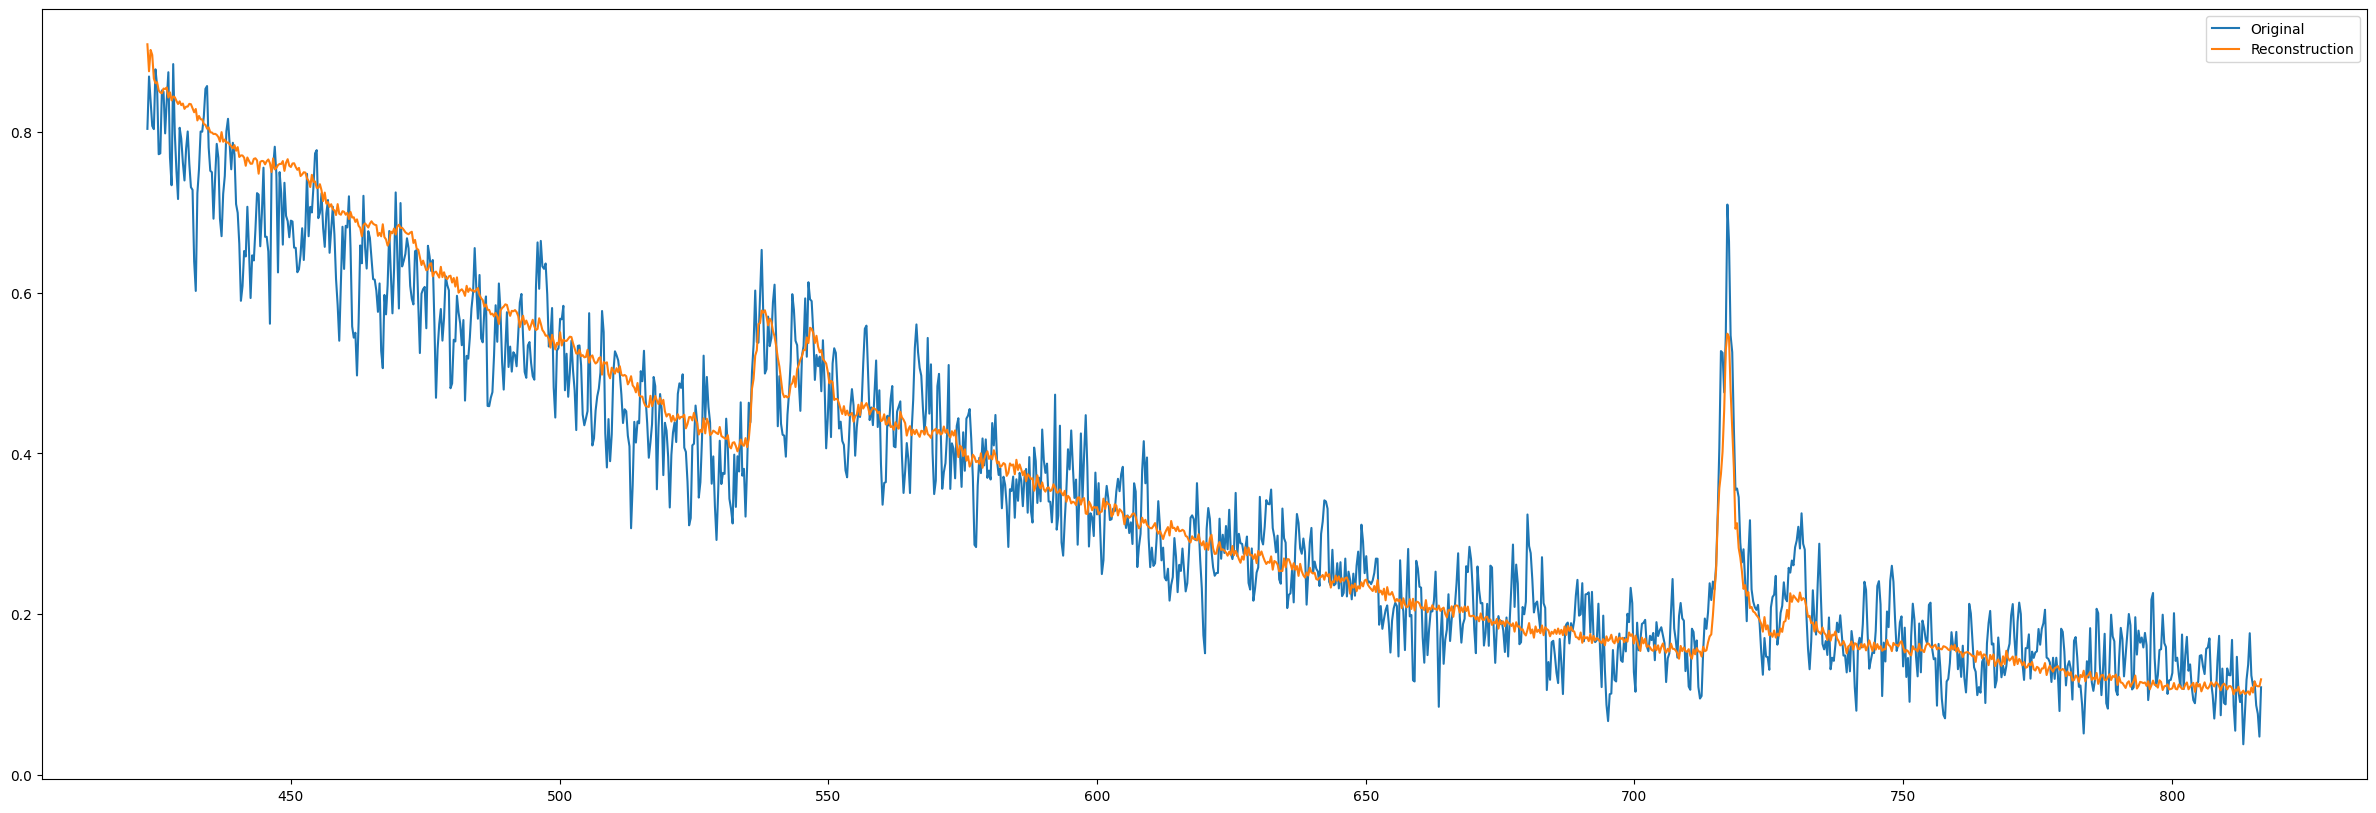

In [7]:
import matplotlib.pyplot as plt
from anomaly_detection.data.data_loader_V2 import EELSDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = IWAE((1, 24, 24, 1312), latent_dim=48, num_samples=5).to(device)  # Adjust parameters as needed
trained_model.load_state_dict(torch.load("iwae_final_model_updated.pth"))

data = EELSDataset(config)
dataset = data.get_training_sub_images()
dataset = dataset.squeeze(axis=1)
dataset.shape
energy_values = data.get_cropped_energy_values()

def iwae_inference(model, x, num_samples=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Encode the input
        mu_enc, var_enc = model.encode(x)
        std_enc = torch.sqrt(var_enc)
        
        # Generate multiple samples
        z = model.reparameterize(mu_enc.expand(num_samples, -1), 
                                 std_enc.expand(num_samples, -1))
        
        # Decode all samples
        mu_dec, _ = model.decode(z)
        
        # Average the reconstructions
        reconstruction = mu_dec.mean(dim=0)
        
    return reconstruction

input_sub_image = dataset[19]
original = torch.tensor(input_sub_image).unsqueeze(0).unsqueeze(0).float().to('cuda')

reconstruction = iwae_inference(trained_model, original, 10)
reconstruction = reconstruction.cpu().squeeze().numpy()
print(reconstruction.shape)

x, y = (12, 12)

fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(energy_values, input_sub_image[x, y, :], label='Original')
ax.plot(energy_values, reconstruction[x, y, :], label='Reconstruction')
ax.legend()
plt.show()

In [4]:
# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model = IWAE(latent_dim=48, num_samples=5).to(device)  # Adjust parameters as needed
trained_model.load_state_dict(torch.load("iwae_final_model.pth"))

from anomaly_detection.data.data_loader_V2 import EELSDataset

data = EELSDataset(config)
dataset = data.get_training_sub_images()
dataset = dataset.squeeze(axis=1)
dataset.shape

energy_values = data.get_cropped_energy_values()

/tmp/ipykernel_70444/4244738402.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load("iwae_final_model.pth"))


WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)
WARNING | Hyperspy | `signal_type='EELS'` not understood. See `hs.print_known_signal_types()` for a list of installed signal types or https://github.com/hyperspy/hyperspy-extensions-list for the list of all hyperspy extensions providing signals. (hyperspy.io:744)


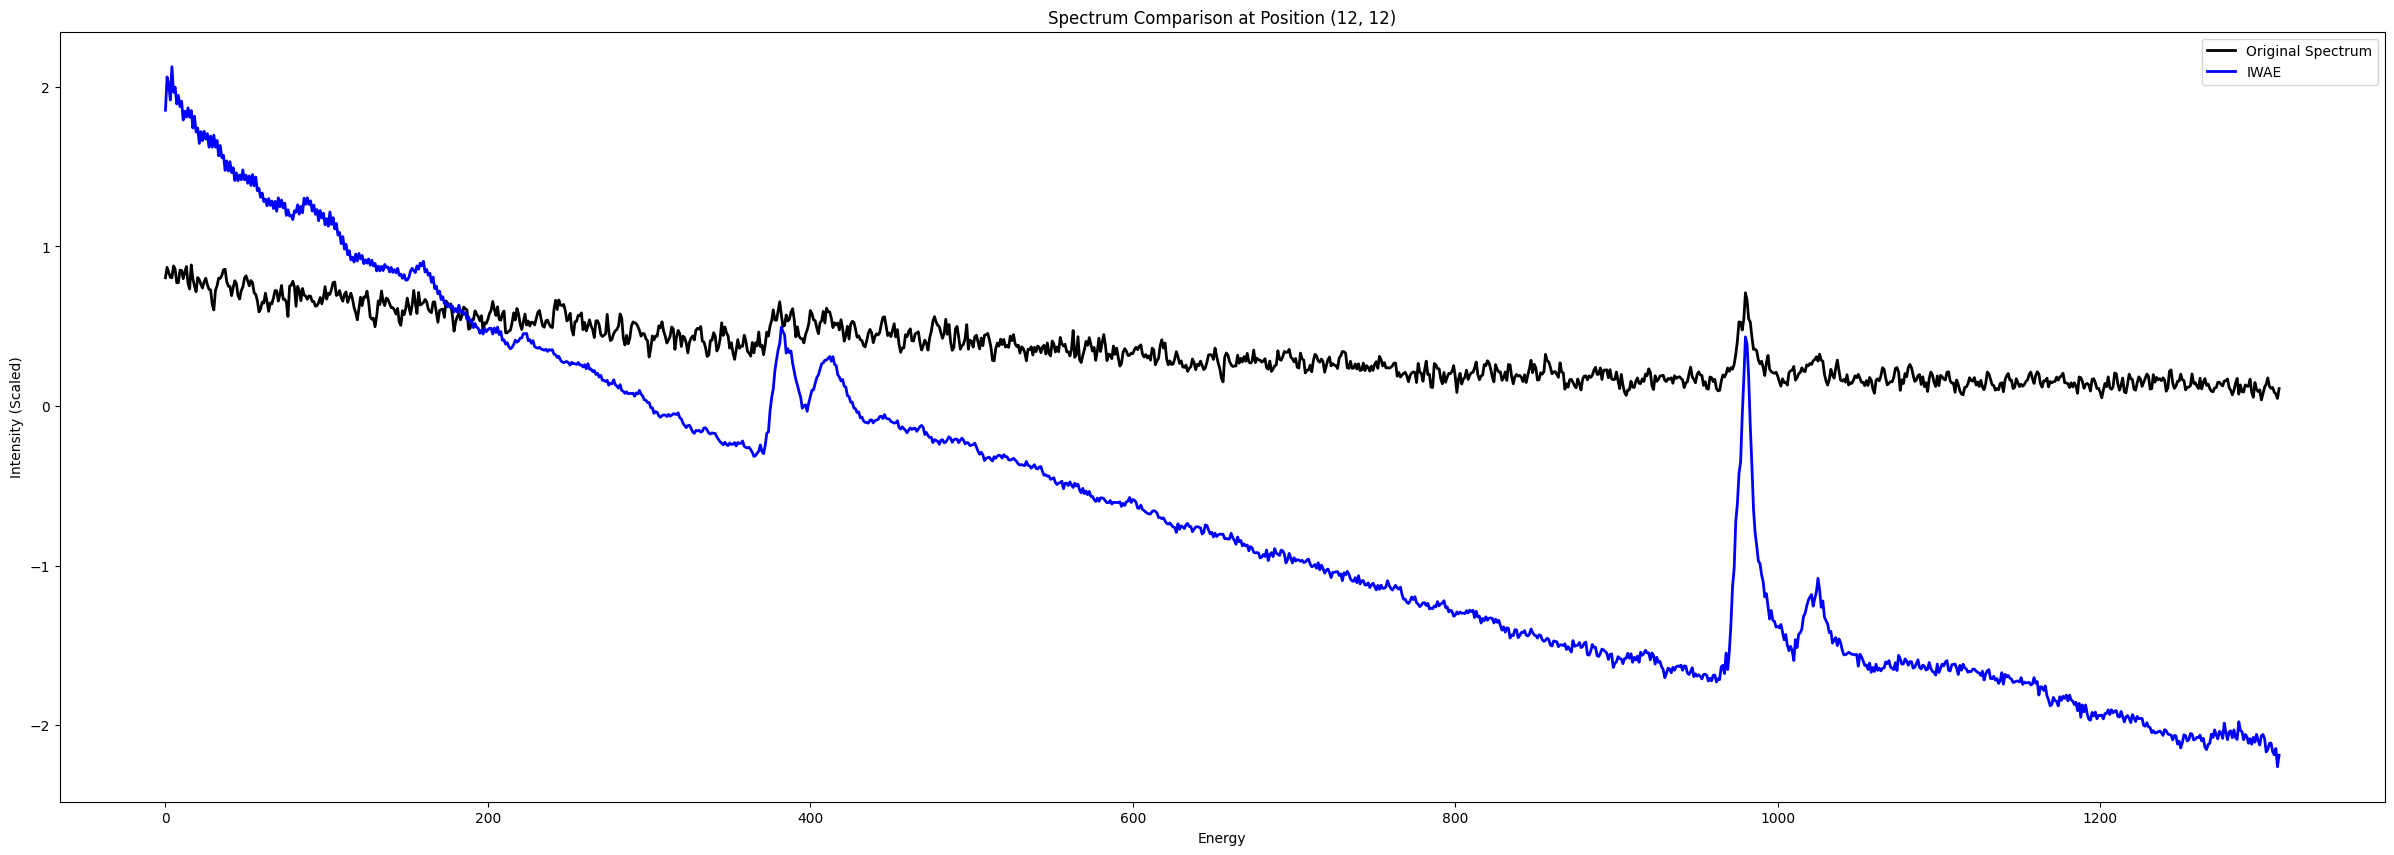

In [12]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def iwae_inference(model, anomalous_sub_image, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        anomalous_tensor = torch.tensor(anomalous_sub_image).unsqueeze(0).unsqueeze(0).float().to(device)
        mu, log_var = model.encode(anomalous_tensor)
        z = model.reparameterize(mu.repeat(num_samples, 1), log_var.repeat(num_samples, 1))
        predictions = model.decode(z).squeeze().cpu().numpy()
    return predictions  # Shape: (num_samples, height, width, channels)

def plot_spectra(original_spectrum, iwae_spectra, x, y, num_samples_to_plot=5):
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Plot original spectrum
    ax.plot(original_spectrum, label="Original Spectrum", color='black', linewidth=2)
    
    # # Plot individual IWAE reconstructions
    # colors = plt.cm.rainbow(np.linspace(0, 1, num_samples_to_plot))
    # for i, (spectrum, color) in enumerate(zip(iwae_spectra[:num_samples_to_plot], colors)):
    #     scaled_spectrum = min_max_scale(spectrum)
    #     ax.plot(scaled_spectrum, label=f'IWAE Reconstruction {i+1}', color=color, alpha=0.7)

    ax.plot(iwae_spectra, label="IWAE", color='blue', linewidth=2)
    
    ax.set_xlabel("Energy")
    ax.set_ylabel("Intensity (Scaled)")
    ax.set_title(f"Spectrum Comparison at Position ({x}, {y})")
    ax.legend()
    plt.show()

input_sub_image = dataset[19]

predictions = iwae_inference(trained_model, input_sub_image, device)

# Plot the results
x, y = (12, 12)
original_spectrum = input_sub_image[x, y]
iwae_spectra = predictions[0, x, y]  # Get spectra for all samples at (x, y)
plot_spectra(original_spectrum, iwae_spectra, x, y)